# Little's Law simulation 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

In [51]:
mean_arrival_rate = 15.0
mean_interarrival_time = 1.0 / mean_arrival_rate

num_events = 3000
num_bins = int(num_events / mean_arrival_rate)

#mean_service_rate = 12.0
#mean_service_time = 1.0 / mean_service_rate

In [52]:
interarrival_times = rng.exponential(scale=mean_interarrival_time, size=num_events)

In [53]:
interarrival_times

array([0.15995065, 0.1833172 , 0.03507743, ..., 0.05300321, 0.05041162,
       0.03608253])

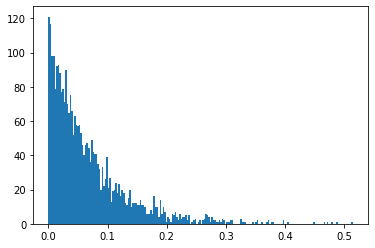

In [54]:
plt.hist(interarrival_times, bins=num_bins)
plt.show()

In [55]:
arrival_times = np.cumsum(interarrival_times)

In [56]:
arrival_times.shape

(3000,)

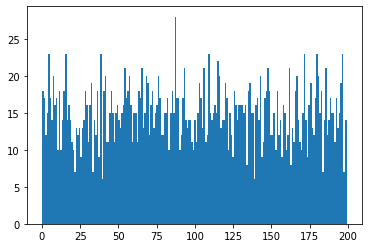

In [57]:
counts, bins, bars = plt.hist(arrival_times, bins=num_bins)
plt.show()

In [58]:
counts

array([18., 17., 12., 15., 23., 17., 14., 20., 16., 17., 10., 18., 10.,
       14., 18., 23., 14., 16., 14., 11., 10.,  7., 13., 12., 13.,  9.,
       13., 14., 18., 16., 11., 16., 19.,  7., 14., 12., 18.,  9., 23.,
        6., 18., 20., 11., 11., 15., 18., 15., 11., 15., 16., 14., 13.,
       15., 16., 21., 17., 18., 20., 16., 11., 15., 15., 11., 18., 17.,
       21., 13., 15., 20., 19., 12., 16., 18., 13., 15., 16., 20., 17.,
       12., 12., 15., 15., 17., 10., 15., 18., 15., 28., 17., 17., 10.,
       12., 17., 21., 14., 13., 14., 14., 11., 10., 14., 11., 15., 19.,
       17., 13., 21., 11., 12., 23., 15., 14., 15., 16., 15., 22., 20.,
       13., 14., 14., 19., 17., 10., 15., 12.,  9., 18., 16., 14., 16.,
       16., 16., 15., 16.,  8., 18., 19., 15., 15.,  6., 16., 17., 14.,
       20.,  9., 11., 17., 18., 21., 18., 12., 12., 15., 10., 18., 12.,
       14.,  9., 16., 15., 10., 12., 21.,  8., 13., 11., 18., 20., 14.,
       11., 10., 15., 23., 14.,  9., 16., 19., 13., 12., 17., 23

In [59]:
np.mean(counts)

15.0